<a href="https://colab.research.google.com/github/joampc/TFM2023/blob/main/notebooks/Food_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Imports**

In [6]:
import pandas as pd
import numpy as np
import csv
import re   #expresion regulares
import json
import matplotlib.pyplot as plt
import textwrap #hacer wrap al texto
import zipfile  # trabajar con ficheros zip
import ast #analizar cadenas y convertirlas en listas
import difflib # encontrar cadenas similares
import spacy
import nltk




In [2]:
!python -m spacy download en_core_web_lg


2023-07-24 14:03:14.280452: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


#**Google Drive Connect**

In [3]:
""" lectura """
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [ ]:
# Ir a Google Drive , hacer clic derecho sobre la carpeta compartida (Compartida conmigo o Shared with me) y seleccionar Organizar/Añadir acceso directo
# seleccionar en todas las ubicaciones Mi Unidad, y darle Añadir, de esta forma la carpeta TFM aparecera en la lista de carpetas del drive de Google y se podra acceder desde collab.
# COn este comando  lista todo dentro del drive
!ls "/content/drive/MyDrive"


 Alimentos	   'CV Formato Conciso.doc'	    Specs
'Colab Notebooks'  'Gastos Febrero.gsheet'	    TFM
 Colab_Notebooks    HeartDisease_prediction.ipynb


#**Cargar listado componentes de la base BEDCA**

In [4]:
df_alimentos = pd.read_csv('/content/drive/MyDrive/TFM/Alimentos/listado_componentes.csv', delimiter='|', quotechar='"')
df_alimentos.head()

,ID,Nombre,English_Name,Nombre_Cientifico,Codigo_foodex,Parte_Comestible,Descripcion
0,746,Aceite de algodón,Cotton oil,NaN,- () - (),100.0,NaN
1,747,Aceite de cacahuete,Peanut oil,NaN,- () - (),100.0,NaN
2,748,Aceite de coco,Coconut oil,NaN,- () - (),100.0,NaN
3,753,Aceite de colza,Rape oil,NaN,- () - (),100.0,NaN
4,749,Aceite de germen de trigo,Wheat germ oil,NaN,- () - (),100.0,NaN


In [ ]:
#cantidad de alimentos
print(f'Número de filas: {df_alimentos.shape[0]}')


Número de filas: 1052


In [ ]:
df_alimentos['ID'].nunique()


968

In [ ]:
df0 = pd.read_csv('/content/drive/MyDrive/TFM/Alimentos/componentes_A.csv' , delimiter='|')
df0.head()

,ID,Grupo,Componente,Valor,Unidad,Fuente
0,746,Proximales,alcohol (etanol),0,g,310
1,746,Proximales,"energía, total",3700 (888),kJ (kcal),236
2,746,Proximales,"grasa, total (lipidos totales)",100,g,30
3,746,Proximales,"proteina, total",0,g,30
4,746,Proximales,agua (humedad),0,g,7


#*Uniendo la composicion de todos los componentes*

In [5]:
# uniendo todos los datasets de la composicion de alimentos
ruta_base = '/content/drive/MyDrive/TFM/Alimentos/componentes_'

# Lista para almacenar los DataFrames individuales
dfs = []

# Recorrer los archivos correspondientes a cada letra
for letra in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']:
    ruta_archivo = f"{ruta_base}{letra}.csv"
    df = pd.read_csv(ruta_archivo, delimiter='|')
    dfs.append(df)

# Combinar los DataFrames en uno solo
df_composicion = pd.concat(dfs)



# esta es la Información de composición (por 100 g de porción comestible), se repiten varias filas por el mismo ID de alimentos, es probable que esta tabla haya que pivotarla
df_composicion.head()

,ID,Grupo,Componente,Valor,Unidad,Fuente
0,746,Proximales,alcohol (etanol),0,g,310
1,746,Proximales,"energía, total",3700 (888),kJ (kcal),236
2,746,Proximales,"grasa, total (lipidos totales)",100,g,30
3,746,Proximales,"proteina, total",0,g,30
4,746,Proximales,agua (humedad),0,g,7


In [ ]:
num_filas = df_composicion.shape[0]
print("Número de filas:", num_filas)

Número de filas: 39012


In [ ]:
# revisando todo lo que pertenece a un componente
df_746 = df_composicion[df_composicion['ID'] == 746]
print(df_746)

     ID                Grupo  \
0   746           Proximales   
1   746           Proximales   
2   746           Proximales   
3   746           Proximales   
4   746           Proximales   
5   746  Hidratos de Carbono   
6   746  Hidratos de Carbono   
7   746               Grasas   
8   746               Grasas   
9   746               Grasas   
10  746               Grasas   
11  746               Grasas   
12  746               Grasas   
13  746               Grasas   
14  746               Grasas   
15  746               Grasas   
16  746               Grasas   
17  746               Grasas   
18  746               Grasas   
19  746               Grasas   
20  746               Grasas   
21  746            Vitaminas   
22  746            Vitaminas   
23  746            Vitaminas   
24  746            Vitaminas   
25  746            Vitaminas   
26  746            Vitaminas   
27  746            Vitaminas   
28  746            Vitaminas   
29  746            Vitaminas   
30  746 

In [ ]:
# revisando las unidades presentes en las columna unidad
df_composicion['Unidad'].unique()

array(['g', 'kJ (kcal)', '-', 'mg', 'ug'], dtype=object)

In [ ]:
#tipos de las columnas
print(df_composicion.dtypes)


ID            object
Grupo         object
Componente    object
Valor         object
Unidad        object
Fuente        object
dtype: object


In [ ]:
# contando cuantos elementos tienen en el valor traza
print(df_composicion[df_composicion['Valor'] == 'traza']['Valor'].value_counts())

traza    1468
Name: Valor, dtype: int64


In [ ]:
# ver los valores no numericos que estan en la columna valor y q no corresponde al valor de la energia que tiene parentesis
valores_numericos = pd.to_numeric(df_composicion['Valor'], errors='coerce')
valores_no_numericos = df_composicion.loc[(valores_numericos.isna()) & (df_composicion['Unidad'] != 'kJ (kcal)'), 'Valor'].unique()

print(valores_no_numericos)

['-' 'traza' nan]


In [ ]:
# ver registros que tiene valor NAN en valor, revisando el site, son aquellos que no tienen nada en esa celda
registros_nan = df_composicion[df_composicion['Valor'].isna()]
registros_nan.head()


,ID,Grupo,Componente,Valor,Unidad,Fuente
1277,2473,Minerales,ioduro,NaN,ug,258
1477,2364,Minerales,ioduro,NaN,ug,38
1885,2183,Hidratos de Carbono,"fibra, dietetica total",NaN,g,30
1903,2183,Vitaminas,Viamina E equivalentes de alfa tocoferol de ac...,NaN,mg,30
1917,2183,Minerales,ioduro,NaN,ug,30


#*Modificando algunos valores de la composicion para unificar unidades*

In [6]:
# vamos a considerar que aquellos alimentos que en el valor de un componente tienen un valor de traza, aunque es muy pequeño, puede ser considerado peligroso en caso de las alergias,
# inicialmente le voy a poner -1, cuando tenga todos los valores en mg se le puede asignar un valor menor que el menor valor de la columna valor en mg
# las medidas estan en gramos,miligramos y microgramos, vamos a unificar todo a miligramos
def convert_to_mg(value, unit):
    if pd.isna(value) or value == '-':
        return value
    elif value == 'traza':
        return -1
    elif unit == 'g':
        return float(value) * 1000
    elif unit == 'ug':
        return float(value) / 1000
    elif unit == 'kJ (kcal)':
        values = re.findall(r'\d+', value)
        return {
            'energia_Kcal': values[1],
            'energia_KJ': values[0]
        }
    else:
        return value
df_composicion['Valor'] = df_composicion.apply(lambda row: convert_to_mg(row['Valor'], row['Unidad']), axis=1)
df_composicion.head(10)

,ID,Grupo,Componente,Valor,Unidad,Fuente
0,746,Proximales,alcohol (etanol),0.0,g,310
1,746,Proximales,"energía, total","{'energia_Kcal': '888', 'energia_KJ': '3700'}",kJ (kcal),236
2,746,Proximales,"grasa, total (lipidos totales)",100000.0,g,30
3,746,Proximales,"proteina, total",0.0,g,30
4,746,Proximales,agua (humedad),0.0,g,7
5,746,Hidratos de Carbono,"fibra, dietetica total",0.0,g,30
6,746,Hidratos de Carbono,carbohidratos,0.0,g,30
7,746,Grasas,ácido graso 22:6 n-3 (ácido docosahexaenóico),-,-,-
8,746,Grasas,"ácidos grasos, monoinsaturados totales",17800.0,g,30
9,746,Grasas,"ácidos grasos, poliinsaturados totales",51900.0,g,30


In [ ]:
# buscar el minimo valor mayor que 0, esto nos servira para imputar los que digan traza por un valor muy peque;o pero no 0 teniendo en cuenta los alergicos
def find_min_value(df):
    filtered_df = df.loc[(df['Valor'] != '-') & (df['Valor'].notna()) & (df['Valor'] != -1) & (df['Unidad'] != 'kJ (kcal)'), ['ID', 'Valor', 'Componente']]
    filtered_df['Valor'] = pd.to_numeric(filtered_df['Valor'], errors='coerce')
    filtered_df = filtered_df[filtered_df['Valor'] > 0]
    if not filtered_df.empty:
        min_value = filtered_df['Valor'].min()
        min_value_row = filtered_df.loc[filtered_df['Valor'] == min_value, ['ID', 'Valor', 'Componente']].iloc[0]
        return min_value_row
    else:
        return None
min_value_row = find_min_value(df_composicion)
if min_value_row is not None:
    print('ID:', min_value_row['ID'])
    print('Valor mínimo:', min_value_row['Valor'])
    print('Componente:', min_value_row['Componente'])

ID: 790
Valor mínimo: 1.6999999999999998e-06
Componente: Vitamina A equivalentes de retinol de actividades de retinos y carotenoides


In [ ]:
# Filtrar registros duplicados
duplicates = df_composicion[df_composicion.duplicated(subset=['ID', 'Componente'], keep=False)]

# Mostrar registros duplicados
len(duplicates)

1600

In [ ]:
#Buscando un alimento con error en las composiciones
# Filtrar el DataFrame para encontrar una fila con 'acido' en la columna 'Componente' y sin 'Grasas' en la columna 'Grupo'
filtro = (df_composicion['Componente'].str.lower().str.startswith('ácido', na=False)) & (df_composicion['Grupo'] != 'Grasas')
fila = df_composicion.loc[filtro]
# Mostrar la fila resultante
print(fila)

Empty DataFrame
Columns: [ID, Grupo, Componente, Valor, Unidad, Fuente]
Index: []


In [ ]:
filas_2237 = df_composicion.loc[df_composicion['ID'] == 2237]

# Muestra las filas resultantes
print(filas_2237)
#el elemento 2237 tiene una estructura erronea en la base de datos teniendo en cuenta que es un elemento que no aportara mucho (Nispero conserva en su jugo) y que muchos de sus valores nutricionales
# estan vacio vamos a eliminarlo de los datasets

       ID       Grupo                                         Componente  \
800  2237  Proximales             ácidos grasos, monoinsaturados totales   
801  2237  Proximales             ácidos grasos, poliinsaturados totales   
802  2237  Proximales                    ácidos grasos saturados totales   
803  2237  Proximales                         ácido graso 12:0 (láurico)   
804  2237  Proximales                 ácido graso 14:0 (ácido mirístico)   
805  2237  Proximales                 ácido graso 16:0 (ácido palmítico)   
806  2237  Proximales                 ácido graso 18:0 (ácido esteárico)   
807  2237  Proximales            ácido graso 18:1 n-9 cis (ácido oléico)   
808  2237  Proximales                                         colesterol   
809  2237  Proximales                                   ácido graso 18:2   
810  2237  Proximales                                   ácido graso 18:3   
811  2237  Proximales          ácido graso 20:4 n-6 (ácido araquidónico)   
812  2237  P

In [7]:
#elimino el alimento con Id 2237 de los dataframes
df_alimentos = df_alimentos.drop(df_alimentos[df_alimentos['ID'] == 2237].index)
df_composicion = df_composicion.drop(df_composicion[df_composicion['ID'] == 2237].index)

#*Pivotando la tabla de composicion para convertir cada componente en una columna donde tenga el valor que corresponda al alimento*

In [8]:
#eliminando valores duplicados
df_unique = df_composicion.drop_duplicates(subset=['ID', 'Componente'])

# Copiar el DataFrame antes de realizar la asignación
df_unique = df_unique.copy()

# definir prefijos correspondientes a cada grupo para agregarlo al nombre de columna asi se sabra a que grupo pertence cuando se pivotee la tabla
prefixes = {
    'Proximales': 'pro_',
    'Hidratos de Carbono': 'hidC_',
    'Grasas': 'gra_',
    'Vitaminas': 'vit_',
    'Minerales': 'min_'
}

# Modificar nombres de columnas y agregar prefijos según el valor de 'Grupo'
df_unique['Componente'] = df_unique.apply(lambda row: f"{prefixes.get(row['Grupo'], '')}{row['Componente']}", axis=1)


# Pivotar el DataFrame
df_pivot = df_unique.pivot(index='ID', columns='Componente', values='Valor')


# Modificar nombres de columnas
df_pivot.columns = df_pivot.columns.str.replace(' ', '_').str.replace(',', '_').str.replace('(', '').str.replace(')', '')
df_pivot.columns = df_pivot.columns.map(lambda x: re.sub('_+', '_', x))


# Separar columna 'energía, total' en 'energia_Kcal' y 'energia_KJ'
energia_values = df_pivot['pro_energía_total'].apply(lambda x: x if isinstance(x, dict) else {})

df_pivot['pro_energia_Kcal'] = energia_values.apply(lambda x: x.get('energia_Kcal'))
df_pivot['pro_energia_KJ'] = energia_values.apply(lambda x: x.get('energia_KJ'))

# Eliminar columnas 'energía_total' del DataFrame resultante
df_pivot.drop(['pro_energía_total'], axis=1, inplace=True)

# Mostrar DataFrame resultante
df_pivot

<ipython-input-8-983ff6f6314e>:21: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_pivot = df_unique.pivot(index='ID', columns='Componente', values='Valor')
<ipython-input-8-983ff6f6314e>:25: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_pivot.columns = df_pivot.columns.str.replace(' ', '_').str.replace(',', '_').str.replace('(', '').str.replace(')', '')
<ipython-input-8-983ff6f6314e>:25: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_pivot.columns = df_pivot.columns.str.replace(' ', '_').str.replace(',', '_').str.replace('(', '').str.replace(')', '')


Componente,gra_colesterol,gra_ácido_graso_12:0_láurico,gra_ácido_graso_14:0_ácido_mirístico,gra_ácido_graso_16:0_ácido_palmítico,gra_ácido_graso_18:0_ácido_esteárico,gra_ácido_graso_18:1_n-9_cis_ácido_oléico,gra_ácido_graso_18:2,gra_ácido_graso_18:3,gra_ácido_graso_20:4_n-6_ácido_araquidónico,gra_ácido_graso_20:5_ácido_eicosapentaenóico,...,vit_Vitamina_B-12,vit_Vitamina_B-6_Total,vit_Vitamina_C_ácido_ascórbico,vit_Vitamina_D,vit_equivalentes_de_niacina_totales,vit_folato_total,vit_riboflavina,vit_tiamina,pro_energia_Kcal,pro_energia_KJ
ID,,,,,,,,,,,,,,,,,,,,,
680,80,-,-,-,-,-,-,-,-,-,...,0.001,0.46,-1,0.0006,7,0.002,0.16,0.9,292,1216
681,8,-,-,-,-,-,-,-,-,-,...,0.0001,0.01,0.5,0.00001,0.7,0.00166,0.08,0.02,38,158
682,100,-,-,-,-,-,-,-,-,-,...,0.0008,0.3,0,0.00001,1.8,0.002,0.11,0.36,546,2277
683,0,-,-,-,-,-,-,-,-,-,...,0.00036,0.15,4.2,0.0003,1.3,0.0211,0.18,0.1,48,201
685,3.4,-,-,-,-,-,-,-,-,-,...,0.0002,0.15,4.2,0.0003,1.3,0.0211,0.13,0.1,112,466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2700,78,20.0,272.0,4436.0,2195.0,8265.0,2051.0,153.0,-,-,...,0.0001,0.4,-,-,5.2,-1,0.34,0.35,254,1058
2701,74,27.0,124.0,1952.0,992.0,3527.0,760.0,47.0,-,-,...,0.0002,0.39,-,-,5.1,-1,0.36,0.64,165,687
2711,88.56,30.0,450.0,3180.0,2060.0,5490.0,580.0,50.0,70.0,10.0,...,0.00236,0.54,-,0.02,3.07,0.0019,0.05,0.1,265,1103


In [9]:
# Restablecer el índice del dataframe df_pivot
df_pivot_idx = df_pivot.reset_index()

# Unir los dataframes utilizando el método join()
df_alimentos_composicion = df_alimentos.join(df_pivot_idx.set_index('ID'), on='ID')
df_alimentos_composicion.drop(['Nombre_Cientifico', 'Codigo_foodex', 'Descripcion'], axis=1, inplace=True)


# Imprimir el resultado
print(df_alimentos_composicion)

        ID                     Nombre           English_Name  \
0      746          Aceite de algodón             Cotton oil   
1      747        Aceite de cacahuete             Peanut oil   
2      748             Aceite de coco            Coconut oil   
3      753            Aceite de colza               Rape oil   
4      749  Aceite de germen de trigo         Wheat germ oil   
...    ...                        ...                    ...   
1047  1079   Zumo de pomelo, envasado       Grapefruit juice   
1048  2248     Zumo de tomate, fresco    Tomato, fresh juice   
1049  2365                Zumo de uva            Grape juice   
1050   791    Zumo de uva y melocotón  Grape and peach juice   
1051  2252  Zumo de zanahoria, fresco    Carrot, fresh juice   

      Parte_Comestible gra_colesterol gra_ácido_graso_12:0_láurico  \
0                100.0              0                            -   
1                100.0              0                            -   
2                100.

In [ ]:
# vamos a hacer un pequeño analisis de los valores en la tabla df_composicion_alimentos
# para facilitarlo vamos a separarlos por los grupos de componentes

# Seleccionar las columnas '
columnas_pro = df_alimentos_composicion.columns.difference(['Nombre', 'English_Name', 'ID'])


# Función para contar los valores numéricos y no numéricos
def contar_valores(columna):
    valores_numericos = columna.astype(str).apply(lambda x: bool(re.match(r'^-?\d+\.?\d*$', x))).sum()
    valores_no_numericos = (~columna.astype(str).apply(lambda x: bool(re.match(r'^-?\d+\.?\d*$', x)))).sum()
    columna_nombre = columna.name

    return pd.Series([columna_nombre, valores_numericos, valores_no_numericos], index=[ 'Col','Valores_Numéricos', 'Valores_No_Numéricos'])


# Aplicar la función a las columnas seleccionadas y transponer el DataFrame resultante
resumen = df_alimentos_composicion[columnas_pro].apply(contar_valores).T

# # Asignar un índice numérico a las filas del DataFrame resumen
# resumen.index = range(len(resumen))

# Mostrar la salida como una tabla formateada
print(resumen.to_string(justify='left', index=False))

Col                                                                             Valores_Numéricos Valores_No_Numéricos
                                                               Parte_Comestible 1040               11                 
                                                                 gra_colesterol 1005               46                 
                                                   gra_ácido_graso_12:0_láurico  163              888                 
                                           gra_ácido_graso_14:0_ácido_mirístico  217              834                 
                                           gra_ácido_graso_16:0_ácido_palmítico  224              827                 
                                           gra_ácido_graso_18:0_ácido_esteárico  222              829                 
                                      gra_ácido_graso_18:1_n-9_cis_ácido_oléico  227              824                 
                                                

In [ ]:
# Función para verificar si un valor es numérico o no numérico
def es_no_numerico(valor):
    if pd.isnull(valor):
        return True
    try:
        float(valor)
        return False
    except ValueError:
        return True
# Obtener las columnas para el análisis
columnas_analisis = df_alimentos_composicion.columns.drop(['ID', 'Nombre', 'English_Name'])

# Obtener los valores únicos no numéricos en cada columna
valores_no_numericos_unicos = df_alimentos_composicion[columnas_analisis].apply(lambda x: set(x.unique()) if x.dtype == 'O' else set())


# Mostrar el resultado
for columna, valores in valores_no_numericos_unicos.items():
    caracteres_no_numericos = [valor for valor in valores if es_no_numerico(valor)]
    print(f"Columna: {columna}")
    print(f"Valores únicos no numéricos: {caracteres_no_numericos}")
    print()

Columna: Parte_Comestible
Valores únicos no numéricos: []

Columna: gra_colesterol
Valores únicos no numéricos: ['-', nan]

Columna: gra_ácido_graso_12:0_láurico
Valores únicos no numéricos: ['-', nan]

Columna: gra_ácido_graso_14:0_ácido_mirístico
Valores únicos no numéricos: ['-', nan]

Columna: gra_ácido_graso_16:0_ácido_palmítico
Valores únicos no numéricos: ['-', nan]

Columna: gra_ácido_graso_18:0_ácido_esteárico
Valores únicos no numéricos: ['-', nan]

Columna: gra_ácido_graso_18:1_n-9_cis_ácido_oléico
Valores únicos no numéricos: ['-', nan]

Columna: gra_ácido_graso_18:2
Valores únicos no numéricos: ['-', nan]

Columna: gra_ácido_graso_18:3
Valores únicos no numéricos: ['-', nan]

Columna: gra_ácido_graso_20:4_n-6_ácido_araquidónico
Valores únicos no numéricos: ['-', nan]

Columna: gra_ácido_graso_20:5_ácido_eicosapentaenóico
Valores únicos no numéricos: ['-', nan]

Columna: gra_ácido_graso_22:6_n-3_ácido_docosahexaenóico
Valores únicos no numéricos: ['-', nan]

Columna: gra_ác

#Histogramas de las columnas numericas

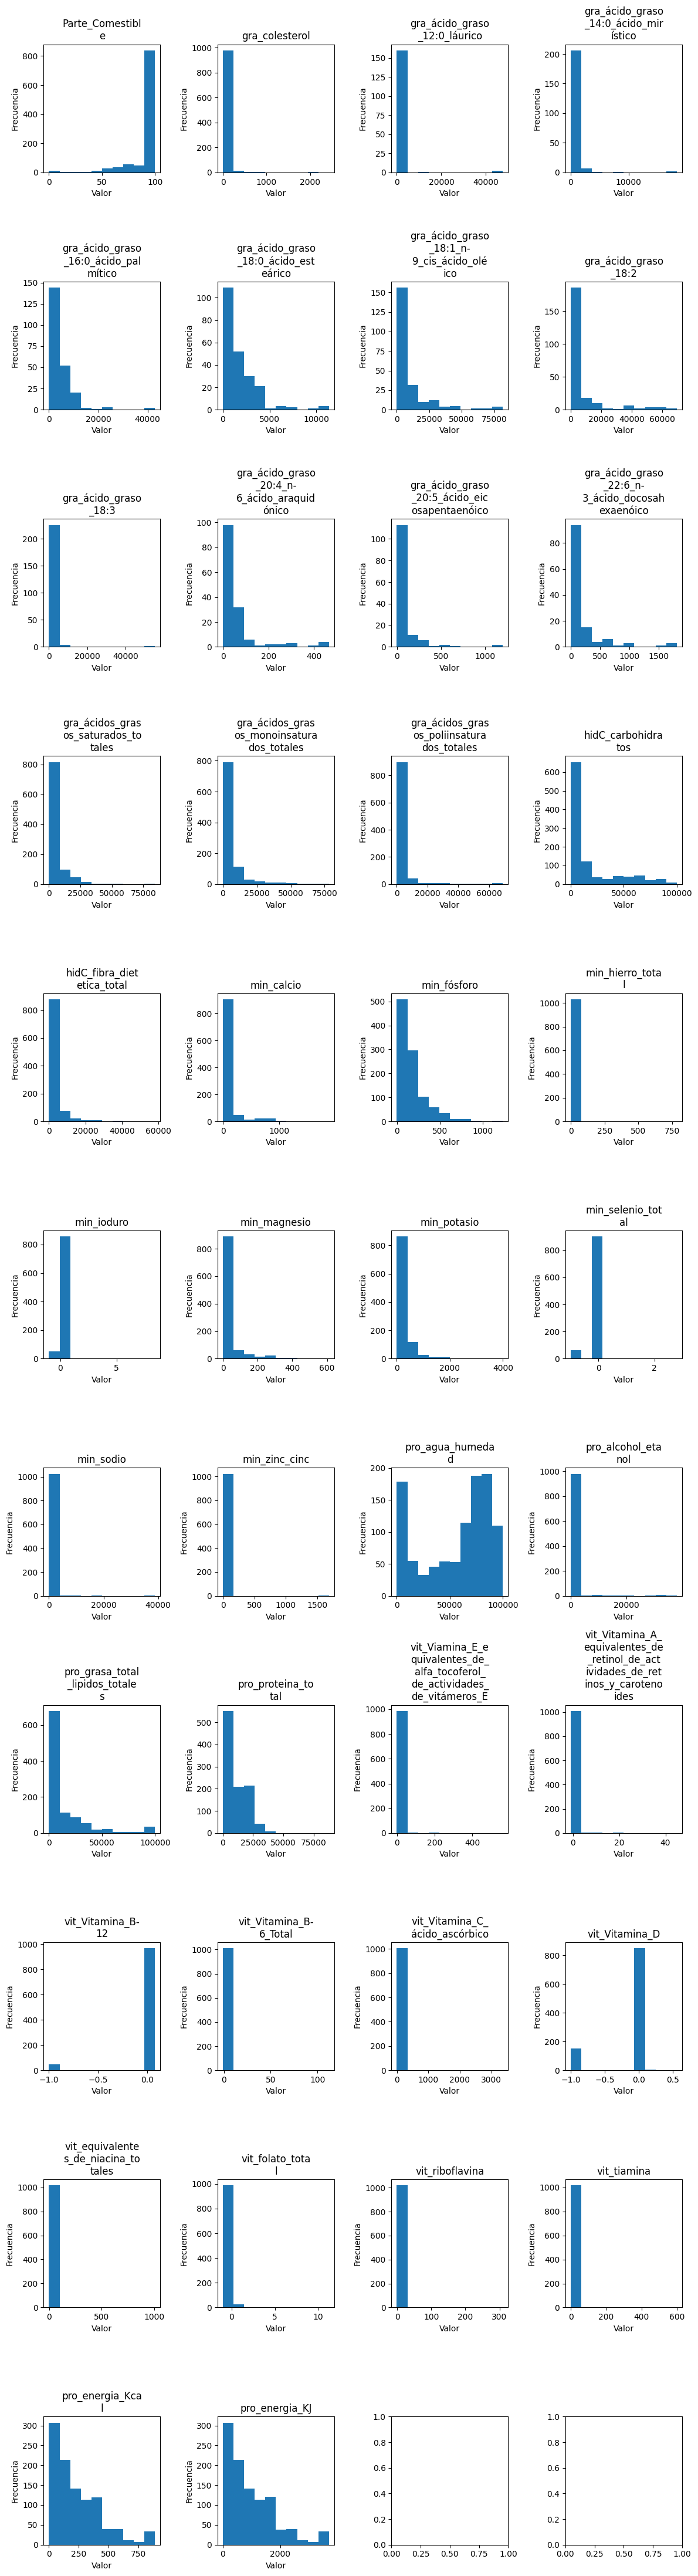

In [ ]:
# Seleccionar las columnas numéricas excluyendo la columna 'ID'
columnas_numericas = df_alimentos_composicion.columns.drop(['ID', 'Nombre', 'English_Name'])

# Definir el número de columnas por fila
num_columnas_por_fila = 4

# Calcular el número total de filas necesarias
num_filas = (len(columnas_numericas) + num_columnas_por_fila - 1) // num_columnas_por_fila

# Generar los subplots
fig, axs = plt.subplots(num_filas, num_columnas_por_fila, figsize=(12, 4*num_filas))

# Generar histogramas para cada columna numérica
for i, columna in enumerate(columnas_numericas):
    # Filtrar los valores no numéricos y NaN
    valores_numericos = df_alimentos_composicion[columna].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()

    # Excluir los valores '-' si existen
    valores_numericos = valores_numericos[valores_numericos != '-']

    # Calcular la posición del subplot
    fila = i // num_columnas_por_fila
    columna = i % num_columnas_por_fila

    # Generar el histograma en el subplot correspondiente
    axs[fila, columna].hist(valores_numericos, bins=10)
    nombre_columna = df_alimentos_composicion.columns[i+3]
    nombre_wrap = '\n'.join(textwrap.wrap(nombre_columna, width=15))

    axs[fila, columna].set_title(nombre_wrap)


    axs[fila, columna].set_xlabel("Valor")
    axs[fila, columna].set_ylabel("Frecuencia")

# Ajustar los espacios entre los subplots
plt.tight_layout()

# Mostrar los gráficos
plt.show()
# aqui faltara por definir que valor le damos al valor traza , y que hacer con NA, ademas de con los valores que tienen '-'

#*Otros datasets de la base BEDCA, grupos y descripcion de componentes*

In [ ]:

#el fichero grupo de alimentos puede servir para agrupar los ingredientes
df_grupos = pd.read_csv('/content/drive/MyDrive/TFM/Alimentos/grupos.csv', delimiter='|')
df_grupos.head()

,ID Select,Texto,ID
0,1,Lácteos y derivados,2479
1,1,Lácteos y derivados,2480
2,1,Lácteos y derivados,2481
3,1,Lácteos y derivados,2482
4,1,Lácteos y derivados,2519


In [ ]:
grupos =df_grupos['Texto'].unique().tolist()
for grupo in grupos:
  print(grupo)

Lácteos y derivados
Huevos y derivados
Cárnicos y derivados
Pescados, moluscos, reptiles, crustáceos y derivados
Grasas y aceites
Cereales y derivados
Legumbres, semillas, frutos secos y derivados
Verduras, hortalizas y derivados
Frutas y derivados
Azúcar, chocolate y derivados
Bebidas (no lácteas)
Miscelánea


In [ ]:
#esto es un dataset informativo que describe lo que significa cada elemento de la composicion de los alimentos
df_desc_componente = pd.read_csv('/content/drive/MyDrive/TFM/Alimentos/descripcion_componentes.csv', delimiter='|')
df_desc_componente.shape[0]
df_desc_componente.head(40)

,componente,Descripcion
0,alcohol (etanol),Componente de las bebidas alcohólicas obtenida...
1,"energía, total",La energía expresa las calorías que un determi...
2,"grasa, total (lipidos totales)",La grasa es un macronutriente que aporta gran ...
3,"proteina, total",La proteína es un macronutriente cuya principa...
4,agua (humedad),El contenido de agua de un alimento determina ...
5,"fibra, dietetica total",La fibra dietética es un componente de los ali...
6,carbohidratos,Este componente es uno de los macronutrientes ...
7,ácido graso 22:6 n-3 (ácido docosahexaenóico),NaN
8,"ácidos grasos, monoinsaturados totales",Son componentes de las grasas de los alimentos...
9,"ácidos grasos, poliinsaturados totales",Son componentes de las grasas que se encuentra...


#**Fichero de recetas de Hugging**

In [10]:
!pip install nltk


#**Unzip dataset**

In [ ]:
# Ruta del archivo ZIP
ruta_zip = '/content/drive/MyDrive/TFM/dataset.zip'

# Directorio de destino para la extracción
directorio_destino = '/content/drive/MyDrive/TFM/'


# Abrir el archivo ZIP
with zipfile.ZipFile(ruta_zip, 'r') as zip_ref:
    # Extraer todos los archivos en el directorio de destino
    zip_ref.extractall(directorio_destino)

#**Load Dataset**

In [7]:

# Ruta completa del archivo CSV extraído
ruta_csv = '/content/drive/MyDrive/TFM/dataset/full_dataset.csv'

# cargarlo en un DataFrame de pandas


df_recipes = pd.read_csv(ruta_csv)
df_recipes.head()

,Unnamed: 0,title,ingredients,directions,link,source,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."


In [14]:
pd.set_option('display.max_colwidth', None)

print(df_recipes.loc[:10, 'ingredients'])

0                                                                                                                                      ["1 c. firmly packed brown sugar", "1/2 c. evaporated milk", "1/2 tsp. vanilla", "1/2 c. broken nuts (pecans)", "2 Tbsp. butter or margarine", "3 1/2 c. bite size shredded rice biscuits"]
1                                                                                                                                                                                                           ["1 small jar chipped beef, cut up", "4 boned chicken breasts", "1 can cream of mushroom soup", "1 carton sour cream"]
2                                                                                                                                                                      ["2 (16 oz.) pkg. frozen corn", "1 (8 oz.) pkg. cream cheese, cubed", "1/3 c. butter, cubed", "1/2 tsp. garlic powder", "1/2 tsp. salt", "1/4 tsp. pepper"]
3                              

In [ ]:
print(df_recipes.shape[0])

468385


#**Columna NER** Eliminar Duplicados, plurales y ordenar

In [ ]:
#from wikipedia
#El Reconocimiento de entidades nombradas (NER por sus siglas en inglés) (también conocido como extracción de entidades)
# es una tarea de extracción de información que busca localizar y clasificar en categorías predefinidas, como personas, organizaciones,
#lugares, expresiones de tiempo y cantidades, las entidades nombradas encontradas en un texto.


def eliminar_plurales(ingrediente):
    if ingrediente.endswith("s"):
        return ingrediente[:-1]
    else:
        return ingrediente
df_copia = df_recipes.copy()

# Eliminar los valores nulos o NaN en la columna NER
df_copia = df_copia.dropna(subset=['NER'])

# Obtener todos los registros de la columna NER como una lista de cadenas
lista_ner_str = df_copia['NER'].tolist()

# Convertir las cadenas de la lista en listas reales de ingredientes utilizando ast.literal_eval()
lista_ner_listas = [ast.literal_eval(ner_str) for ner_str in lista_ner_str]

# Crear una lista con todos los elementos únicos
lista_ingredientes_unicos = list(set(ingrediente for lista in lista_ner_listas for ingrediente in lista))

# Eliminar caracteres no deseados y espacios en blanco al principio y al final de cada ingrediente
lista_ingredientes_unicos = [re.sub(r'^[^A-Za-z0-9]+|[^A-Za-z0-9]+$', '', ingrediente) for ingrediente in lista_ingredientes_unicos]

# Eliminar plurales de los ingredientes
lista_ingredientes_unicos_NER = [eliminar_plurales(ingrediente) for ingrediente in lista_ingredientes_unicos]

# Convertir el conjunto a una lista y ordenar alfabéticamente
lista_ingredientes_NER = sorted(list(lista_ingredientes_unicos_NER))

lista_ingredientes_NER = [ingrediente.strip().lower() for ingrediente in lista_ingredientes_NER]

# Crear un DataFrame con los ingredientes únicos
df_ingredientes_NER = pd.DataFrame({'ingredientes': lista_ingredientes_NER})

# Eliminar duplicados después de ordenar
df_ingredientes_unicos_NER = df_ingredientes_NER.drop_duplicates(subset='ingredientes', keep='first')

# Obtener la lista de ingredientes únicos final
ingredientes_unicos_NER = df_ingredientes_unicos_NER['ingredientes'].tolist()


In [ ]:
for ingrediente in ingredientes_unicos_NER[2000:2500]:
    print(ingrediente)

# Imprimir la cantidad total de ingredientes únicos
print("Cantidad total de ingredientes únicos:", len(ingredientes_unicos_NER))


duncan hines traditions vanilla cake mix
dupree chili mix
durkee
durkee dressing
durkee cheese sauce
durkee chili mix
durkee meat marinade
durkee mustard
durkee red hot sauce
durkee sauce
dusting of paprika
dutch
dutch cheese
dutch chocolate milk
dutch chocolate mix
dutch noodle
dynasty
e
egg substitute
eagle
easter
eastern market carrie
eastern spice
eastpoint shrimp
eat
ecclesiaste
eckerd sausage
edisto
egg
egg beater
egg custard mix
egg noodle
egg pastry
egg salad
egg sauce
egg scrambler
egg white
egg yoke
egg yolk
egg roll
egg roll wrapper
egg(
egg-substitute
eggbeater
eggnog dessert sauce
eggplant
eggplant-tomato sauce
elbow macaroni
elderberry juice
electric ice cream
elmer
elmer'
elmer's white glue
elmers glue
elpato hot tomato sauce
embasa green chili salsa
emge smoked ham
emmenthaler cheese
empire apple
empty
empty shell
enchilada sauce
enchilada mix
end
english cheese
english cheese spread
english muffin
english pea
english roast
english sharp
english ale
english cheese dip
e

In [ ]:
!pip install python-Levenshtein


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 45.9 MB/s eta 0:00:00


In [ ]:
from difflib import SequenceMatcher# Crear una lista para almacenar los resultados
resultados = []

df_cp_alimentos = df_alimentos.copy()
df_cp_alimentos['English_Name'] = df_cp_alimentos['English_Name'].str.lower()

# Comparar cada entidad única del NER con los nombres en inglés de alimentos
for entidad_ner in ingredientes_unicos_NER:
    mejor_match = max(df_cp_alimentos['English_Name'], key=lambda nombre: SequenceMatcher(None, entidad_ner, nombre).ratio())
    score = SequenceMatcher(None, entidad_ner, mejor_match).ratio()
    resultados.append((entidad_ner, mejor_match, score))

# Crear un DataFrame con los resultados
df_resultados = pd.DataFrame(resultados, columns=['NER', 'Mejor_Match', 'Score'])

print(df_resultados)

                       NER         Mejor_Match     Score
0                                   cotton oil  0.000000
1                        a                crab  0.400000
2      a cassell courtyard  goat cheese, cured  0.540541
3                     a no             anchovy  0.545455
4               a heartfol            escarole  0.555556
...                    ...                 ...       ...
35316            zuzcchini              tahini  0.533333
35317       zweiback crumb         breadcrumbs  0.560000
35318     zwieback biscuit  black currant, raw  0.470588
35319      zwieback cookie          tea cookie  0.720000
35320       zwieback-style         pike, baked  0.480000

[35321 rows x 3 columns]


In [ ]:
# Ordenar el DataFrame por la columna 'Score' de mayor a menor
df_resultados_sorted = df_resultados.sort_values(by='Score', ascending=False)

# Mostrar el DataFrame ordenado
print(df_resultados_sorted[:100])

                  NER     Mejor_Match  Score
24335            miso            miso    1.0
4233         mushroom        mushroom    1.0
12747  coffee liqueur  coffee liqueur    1.0
6424          vanilla         vanilla    1.0
1224           cherry          cherry    1.0
...               ...             ...    ...
34150          whisky          whisky    1.0
26223            pear            pear    1.0
11000          caviar          caviar    1.0
11264        chestnut        chestnut    1.0
5917       strawberry      strawberry    1.0

[100 rows x 3 columns]


In [ ]:
print(df_resultados_sorted[df_resultados_sorted['Score'] == 1]['Score'].count())
print(df_resultados_sorted[df_resultados_sorted['Score'] > 0.9]['Score'].count())
#print(df_resultados[(df_resultados['Score'] >= 0.8) & (df_resultados['Score'] <= 1)])
df_resultados[(df_resultados_sorted['Score'] >= 0.8) & (df_resultados_sorted['Score'] <= 0.9)][:50]

182
294


<ipython-input-79-f21a2b1781bc>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_resultados[(df_resultados_sorted['Score'] >= 0.8) & (df_resultados_sorted['Score'] <= 0.9)][:50]


,NER,Mejor_Match,Score
8,a-live juice,lime juice,0.818182
43,alive,olive,0.800000
44,alive juice,lime juice,0.857143
65,almond,salmon,0.833333
73,almond paste,"almond, toast",0.800000
95,american cheese,parmesan cheese,0.800000
117,anchovie,anchovy,0.800000
157,apple cider vinegar,apple vinegar,0.812500
161,apple jack,apple cake,0.800000
164,apple sauce,apple juice,0.818182


#**Columna Ingredientes**

In [44]:
# aqui estamos haciendo una lista de todos los ingredientes que aparecen en la columna ingredients y ademas los estamos limpiando de unidades y cantidades y espacios no necesarios

# Copiar el DataFrame original para evitar modificar los datos originales
df_copia = df_recipes.copy()

conjunto_ingredientes = set()

# Función para eliminar las cantidades y unidades de medida de un ingrediente
# def eliminar_cantidades(ingrediente):
#     return re.sub(r'\b(?:\d+(?:\s*\d+\/\d+)?(?:\s*-\s*\d+)?|'  # Cantidades como "1 1/2" o "1-2"
#                   r'\d*\s*\.\s*\d+|\.\d+\b)\s*'  # Cantidades como "0.5" o ".5"
#                   r'(?:lb|oz|in|tsp|tbsp|qt|inch|c|ml)\.?(?!\w)\s*|\(.*?\)', '', ingrediente)


# Función para eliminar las cantidades y unidades de medida de un ingrediente
def eliminar_cantidades(ingrediente):
    # Mejorar la expresión regular para retener solo palabras
    return re.sub(r'\b(?:\d+(?:\s*\d+/\d+)?(?:\s*-\s*\d+)?|\d*\.\d+|\.\d+\b)\s*'
                  r'(?:lb|oz|in|tsp|tbsp|qt|inch|c|ml|bag|pkg|pinch)\.?(?!\w)\s*|\(.*?\)|[^a-zA-Z\s]', '', ingrediente)



# Recorrer cada registro de la columna 'ingredients'
for registro in df_copia['ingredients']:
    # Convertir el registro en una lista de ingredientes
    ingredientes = re.findall(r'"([^"]*)"', registro)
    # Limpiar cada ingrediente y agregarlo a la lista
    for ingrediente in ingredientes:
        limpio = eliminar_cantidades(ingrediente.strip())
        # Ignorar ingredientes vacíos y convertir a minúsculas
        if limpio:
            limpio = limpio.lower()  # Convertir a minúsculas
            conjunto_ingredientes.add(limpio)

# Convertir el conjunto a una lista y ordenar alfabéticamente
lista_ingredientes = sorted(list(conjunto_ingredientes))

lista_ingredientes = [ingrediente.strip() for ingrediente in lista_ingredientes if ingrediente.strip()]

# Crear un DataFrame con los ingredientes únicos
df_ingredientes_unicos = pd.DataFrame({'ingredientes': lista_ingredientes})

# Eliminar duplicados después de ordenar
df_ingredientes_unicos = df_ingredientes_unicos.drop_duplicates(subset='ingredientes', keep='first')

# Eliminar registros vacíos en la columna "ingredientes"
df_ingredientes_unicos = df_ingredientes_unicos.dropna(subset=['ingredientes'])

# Ordenar el DataFrame por la columna "ingredientes"
df_ingredientes_unicos = df_ingredientes_unicos.sort_values(by='ingredientes', ascending=True)

# Obtener la lista de ingredientes únicos final
ingredientes_unicos = df_ingredientes_unicos['ingredientes'].tolist()


df_ingredientes_unicos


,ingredientes
200102,a
200104,a sauce
200106,a steak sauce
200107,a to slices john
200108,a bag pickling spices
...,...
353168,zwieback crust
353169,zwieback or graham cracker crumbs
353170,zwieback toast
353171,zwieback toast crushed


In [13]:
!python -m spacy download en_core_web_lg


2023-07-24 14:06:36.052730: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [45]:
#ingredientes_unicos = sorted(set(ingredientes_unicos))

# Imprimir los primeros X ingredientes
for ingrediente in ingredientes_unicos[450:600]:
    print(ingrediente)

# Imprimir la cantidad total de ingredientes únicos
print("Cantidad total de ingredientes únicos:", len(ingredientes_unicos))



a little nutmeg or cinnamon
a little of any type seasoning salt
a little oil
a little oil for rubbing
a little oleo
a little onion
a little onion finely chopped
a little onion flakes
a little onion grated
a little onion juice
a little onion or onion flakes improve flavor
a little onion salt
a little onions
a little orange juice
a little oregano
a little oregano and parsley
a little over bag flour
a little over half of a qt size bag of turnips
a little over parmesan cheese
a little over sugar
a little oyster sauce
a little paprika
a little parmesan
a little parmesan cheese
a little pecans
a little pepper
a little pepper and parsley
a little pinch of grit well mixed with self control
a little pineapple juice
a little powdered sugar
a little prepared mustard
a little red cake color
a little red food coloring
a little red hot pepper
a little red pepper
a little red pimento pepper
a little red wine
a little regular milk
a little salt
a little salt and cinnamon
a little salt and pepper
a lit

In [46]:
import spacy

# Carga el modelo de lenguaje en_core_web_lg
nlp = spacy.load("en_core_web_lg")

# Definimos una función para eliminar cantidades, unidades de medida y cuantificadores
# def eliminar_cantidades_unidades(ingrediente):
#     if not isinstance(ingrediente, str):
#         return ""  # O puedes omitirlo con "return None" si prefieres
#     doc = nlp(ingrediente)
#     # Filtramos las palabras que no son cuantificadores, unidades de medida o etiquetas numéricas
#     ingrediente_limpio = " ".join(token.text.lower() for token in doc if token.pos_ not in ['QUANTIFY', 'NUM', 'SYM'])
#     return ingrediente_limpio.strip()
# Definimos una función para limpiar los ingredientes
def limpiar_ingrediente(ingrediente):
    if not isinstance(ingrediente, str):
        return ""  # O puedes omitirlo con "return None" si prefieres
    doc = nlp(ingrediente)
    # Filtramos las palabras que son sustantivos y tienen más de una letra
    ingredientes_limpio = [token.text.lower() for token in doc if token.pos_ == 'NOUN' and len(token.text) > 1]
    # Eliminar dígitos y caracteres especiales presentes en el texto
    ingredientes_limpio = [re.sub(r'[^a-zA-Z ]', '', token) for token in ingredientes_limpio]
    # Unir términos compuestos
    ingredientes_limpio = " ".join(ingredientes_limpio)
    return ingredientes_limpio.strip()

# Crear una nueva lista con los ingredientes limpios
ingredientes_unicos_limpio = []
for ingrediente in df_ingredientes_unicos['ingredientes'][:1000]:
    ingredientes_limpio = limpiar_ingrediente(ingrediente)
    if ingredientes_limpio:
        ingredientes_unicos_limpio.append(ingredientes_limpio)

# Convertir la lista a un DataFrame
df_ingredientes_unicos_limpio = pd.DataFrame({'ingredientes': ingredientes_unicos_limpio})

# Eliminar registros duplicados después de ordenar
df_ingredientes_unicos_limpio = df_ingredientes_unicos_limpio.drop_duplicates(subset='ingredientes', keep='first')

# Ordenar alfabéticamente
df_ingredientes_unicos_limpio = df_ingredientes_unicos_limpio.sort_values(by='ingredientes', ignore_index=True)

# Imprimir el DataFrame resultante
print(df_ingredientes_unicos_limpio)



                 ingredientes
0               abalone shell
1            abcs shell pasta
2                    allspice
3                     almonds
4       amount cheddar cheese
..                        ...
724                     whisk
725                      wine
726              wine vinegar
727  wintergreen cloves smell
728                  zucchini

[729 rows x 1 columns]


In [47]:
ingredientes_limpios = df_ingredientes_unicos_limpio['ingredientes'].tolist()

for ingrediente in ingredientes_limpios[450:600]:
    print(ingrediente)

# Imprimir la cantidad total de ingredientes únicos
print("Cantidad total de ingredientes limpios:", len(ingredientes_limpios))

pecans
peck slicing pickles
pepper
pepper oregano
pepper parsley
pepper salt
peppercorns
peppers
peppers coloring
peppers pieces
pickles
pie shell
piece bacon butter
pieces bacon
pieces celery
pieces chicken
pieces cubed steak
pig weeks
pile fruit
pimento
pimentos
pinch
pinch adventure
pinch allspice
pinch brook
pinch brook pebbles
pinch cayenne
pinch celery seed
pinch cinnamon
pinch cream
pinch discipline
pinch friendliness
pinch garlic
pinch ginger
pinch grit self control
pinch ground pepper
pinch hope
pinch kindness
pinch laughter
pinch lemon zest
pinch luck
pinch marjoram
pinch meat softener
pinch nutmeg
pinch oregano
pinch paprika
pinch pebbles
pinch pepper
pinch personality
pinch pinch curry
pinch safranine
pinch salt
pinch salt child
pinch salt pepper
pinch salt pepper sugar
pinch seafood seasoning
pinch soda
pinch spice
pinch sugar
pinch tenderness
pinch thyme
pinch unselfishness
pineapple
pineapple juice
pint oysters
pint respect
plums
porcelain type teapot
pork chops
pot
pota

In [51]:
texto_buscar = "consideration"
print(df_recipes[df_recipes['ingredients'].str.contains(texto_buscar, case=False)])

        Unnamed: 0                                             title  \
18504        18504                       Recipe For A Happy Marriage   
59697        59697                       Recipe For A Happy Marriage   
81082        81082                       Recipe For A Happy Marriage   
93468        93468                     A Recipe For A Happy Marriage   
100405      100405                       Recipe For A Happy Marriage   
157433      157433                       Recipe For A Happy Marriage   
164418      164418                       Recipe For A Happy Marriage   
274892      274892                       Recipe For A Happy Marriage   
291887      291887                       Recipe For A Happy Marriage   
341683      341683                       Recipe For A Happy Marriage   
368324      368324  Claire'S Home-Tested Recipe For A Happy Marriage   

                                                                                                                                       

In [52]:
pd.set_option('display.max_colwidth', None)
X = df_copia[df_copia['ingredients'].str.contains("cooked chickpeas, drained, reserve liquid")]
print(X['ingredients'].to_string(index=False))

["1 2/3 c. (15 oz. can) cooked chickpeas, drained, reserve liquid", "1/4 c. tahini (sesame paste)", "1/4 c. lemon juice", "3 large cloves garlic, crushed", "1/2 tsp. ground coriander", "1/4 tsp. cumin", "1/4 tsp. paprika", "water if needed", "2 Tbsp. chopped fresh parsley", "1/4 c. scallions", "dash of cayenne"]
